<h1 style='text-align: center;'> MTMW14 Project 2: Simple Ocean Gyre Model </h1>
<h2 style='text-align: center;'> Student ID: 31827379 </h2>
    
### 1. Introduction

In this project, we implement a simple dynamical model of a wind-driven circulation in a closed ocean basin, based on the work of Stommel (1948). The model can be used to demonstrate western boundary intensification, characterised by the clustering of streamlines at western continental boundaries. This is a prevalent feature in oceanic wind-driven circulations, exemplified by phenomena such as the Gulf stream or the Kuroshio current. 

Considering a rectangular oceanic basin of length $L$ and with a single layer of fluid, we can represent the system with the shallow water equations linearised about a resting state. These are given in Equations 1 and 2.

\begin{align}
&\frac{\partial \eta}{\partial t} + H \nabla \cdot \vec{V} = 0 \\
&\frac{\partial \vec{V}}{\partial t} + (f_0 + \beta y) \hat{k} \times \vec{V} = -g \nabla \eta - \gamma \vec{V} + \frac{\vec{\tau}}{\rho H}
\end{align}

Equations 1 and 2 represent conservation of mass and momentum, respectively, where the prognostic variables are the height perturbation ($\eta$) and the depth integrated horizontal velocity ($\vec{V}$). We have neglected inertial terms since these are assumed to be small, and have further assumed uniform density ($\rho$) and a constant resting height ($H$). Planetary rotation effects are incorporated through the beta plane approximation ($f=f_0 + \beta y$), and the model additionally features a damping term ($\gamma \vec{V}$) to depict momentum dissipation through friction at the ocean floor. In a mid-latitude beta plane, the surface wind stress ($\vec{\tau}$) represents the easterly trade winds over the equatorial half of the basin, and the mid-latitude westerlies over the poleward half. Assuming no meridional wind stress, we model this as a sinusoidal function varying with latitude, as shown in Equation 3.

\begin{align}
\vec{\tau} =
\begin{pmatrix}
\tau_x \\
\tau_y \\
\end{pmatrix}
= \tau_0
\begin{pmatrix}
- \cos\left(\frac{\pi y}{L}\right) \\
0 \\
\end{pmatrix}
\end{align}

In this report we will experiment with different numerical approaches to solving the system of equations outlined in Equations 1 and 2. In Sections 2 we make decisions regarding the model setup, and in Section 3 onwards we will present and discuss the results.

In [1]:
import assignment2 as assign2 # Takes a little while.

### 2. Task A and B: Model setup

#### 2.1 Timestep calculation

To ensure stability of the numerical solution, we use the CFL criterion (Equation 4) to provide an upper bound on the step size ($\Delta t$). This criterion dictates that the distance travelled by the flow in one time step must not exceed the grid spacing, and we are thus limited by two variables: the flow speed ($V_s$) and the grid spacing ($\Delta x$). 

To find the limiting flow speed, we first consider the different types of waves that our model can support. While compression waves, like sound waves, typically travel on the shortest timescales, our assumption of an incompressible fluid means that they cannot exist in our model. Thus, the next fastest waves we need to consider are gravity or inertia-gravity waves. Figure 1 illustrates an example of a gravity wave for the case of no planetary rotation, wind stress or drag terms. To spawn the waves, the height perturbation field is initialised with a 2D Gaussian mountain.

In [2]:
assign2.wavesDemo.displayGravityWave()

,


Figure 1: Gravity waves spawned by initialising the height perturbation field with a 2D Gaussian mountain. Left-hand figure shows the time evolution of the height perturbation, and the right-hand figure shows the velocity field for the same time frame. Reflective boundary conditions are applied for an Arakawa-C grid, and the forward-backward numerical scheme is used with a timestep of $35$s. The domain is a square basin with $L=1000$km, grid spacing $\Delta x=5$km, and resting height $H=1000$m. Make sure to see the notebook version if you're reading the pdf - these are animated!

Kelvin waves, which can be thought of as equatorially trapped gravity waves, are also supported by the model, and travel at the same phase speeds as their unbounded counterparts. Figure 2 shows an example of an equatorially trapped Kelvin wave propagating eastward. Both Kelvin and inertia-gravity waves act to redistribute mass such that pressure gradients are flattened. This means that if a simulation is run until some steady state is reached, these waves will eventually dissipate once an ideal arrangement of mass has been obtained. 

In [3]:
assign2.wavesDemo.displayKelvinWave()

,


Figure 2: Kelvin waves spawned by initialising the height perturbation field with a 2D Gaussian mountain. Left-hand figure shows the time evolution of the height perturbation, and the right-hand figure shows the velocity field. An Arakawa-C grid is used with periodic boundary conditions in the x-direction and reflective boundary conditions in the y-direction. The forward-backward numerical scheme is used with a timestep of $35$s. An equatorial beta plane is included with $\beta=10^{-8} m^{-1}s^{-1}$ to increase the effects of rotation, and the effects of wind-stress or drag are neglected. The domain is a square basin with $L=1000$km centred at $y=0$m. Grid spacing is $\Delta x=5$km and resting height is $H=1000$m.

Rossby waves are also supported by the model for $\beta \neq 0$, since this allows for a background potential vorticity gradient to exist. They can be initiated by geostrophic initial velocities and vertical shear in the height perturbation field, or from flow over mountains, and will eventually dissipate over time. These are typically much slower than inertia-gravity waves, so will not be considered further in our calculation of a suitable timestep. The limiting flow speed that we need to consider is therefore the phase speed of gravity waves, given by $c=\sqrt{gH}$. For a height of $H=1000$m and gravitational acceleration of $g=10ms^{-2}$, the phase speed is calculated as $c=100$m/s.

The grid spacing is the second limiting variable for the CFL criterion. This must be small enough to capture features of interest in the flow, but not too small that we incur excessive computational costs. The feature that we are interested in modelling is the western boundary current in an ocean gyre, and in Stommel (1948) this region is shown to have a width of less than 100km. We therefore choose our grid spacing as $\Delta x=\Delta y=d=25$km, with an absolute upper bound of $d=50$km should we require a coarser mesh. We can now calculate our timestep using the CFL criterion in Equation 4, which modifies the grid spacing for the worst-case scenario of 45&deg; flow over a 2D grid.


\begin{align}
\Delta t \leq \frac{d}{\sqrt{2}V_s}
\end{align}

For a flow speed of $V_s=100$m/s and a grid spacing $d=25$km, the CFL criterion allows us to use a timstep of $\Delta t=176$s. 

#### 2.2 Choice of grid

Stability of our scheme and the quality of solutions is also dependent on our choice of grid. This can be chosen by calculating the ratio of the Rossby radius of deformation (Equation 5) to the grid spacing.

\begin{align}
R_d = \frac{\sqrt{gH}}{f_0}
\end{align}

For a mid-latitude beta plane we have $f_0=10^{-4}s^{-1}$, such that $R_d=10^{6}$m. The ratio of Rossby radius of deformation to the grid spacing is therefore $R_d/d=20$, putting us in the fine grid regime. For this regime we choose to implement the Arakawa-C grid (Figure 3), since this gives the most accurate dispersion relationship for inertia-gravity waves. We implement reflective boundary conditions, such that there is no normal flow and zero $\eta$ flux across the boundaries. In practice, we do not update the boundary velocities since these are always zero, and consequently we do not need to incorporate the flux boundary condition for $\eta$ into the model. 

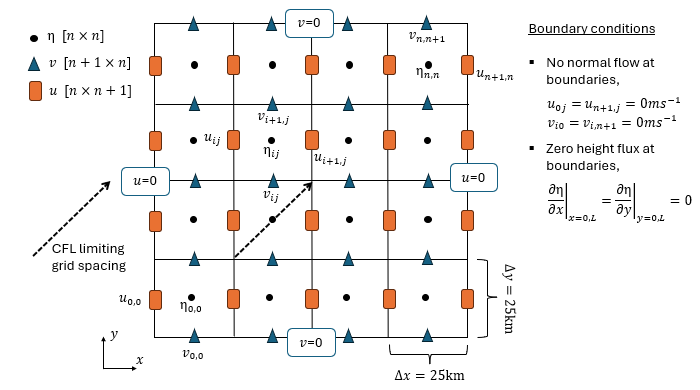

In [4]:
assign2.displayArakawaGrid()

Figure 3: A schematic illustrating the Arakawa-C grid, showing where each variable is stored on the grid. The dashed arrow shows the worst-case flow scenario that must be considered for the CFL criterion. The chosen grid spacing is $d=25$km and we have chosen reflective boundary conditions.

In what follows, we use a forward-backward time scheme (Matsuno 1965) unless stated otherwise. We assume a mid-latitude beta plane such that $f_0=10^{-4}s^{-1}$ and $\beta=10^{-11}m^{-1}s^{-1}$, and our grid domain is $[0 \times L]\times[0 \times L]$ where $L=1000$km. Our drag coefficient is $\gamma=10^{-6}s^{-1}$ and the wind-stress amplitude is $\tau_0=0.2Nm^{-2}$. The fluid density is $\rho=1000kgm^{-3}$, the gravitational acceleration is $g=10ms^{-2}$ and the resting height is $H=1000$m.

### 3. Task C: Steady state analytical solution of the linear model

To provide a benchmark test for our numerical experiments, we consider the analytical solution for steady state derived in Mushgrave (1985). The solution depends on an unknown constant of integration $\eta_0$, which can be taken to be $\eta_0=0$ at the very start of the simulation as the gyre is starting to form. Figure 4 shows contour plots of the velocities and the height perturbation for this solution.

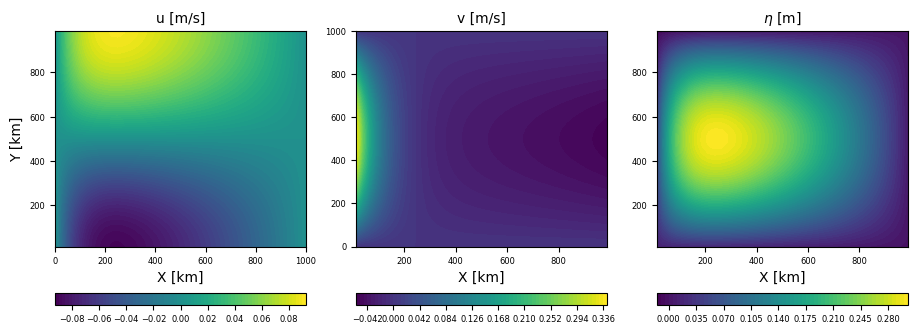

In [5]:
assign2.runTaskC()

Figure 4: Analytical solutions for the gyre at steady state for $\eta_0=0$.

In the exact solution $\eta_{st}(0, L/2)=\eta_0$, such that the final value of $\eta_{st}(0, L/2)$ from the model can be used as a good estimate of $\eta_0$. In what follows, model comparisons to the analytical solution will be done by taking $\eta_0$ from the model's steady state.

### 4. Task D: Numerical solution of the forward-backward time scheme

In this section we consider the numerical solutions of the forward-backward scheme.

### 4.1 Results after 1 day 

The model is initially run for one day and the resulting numerical solutions of the forward-backward scheme are shown in Figure 5.

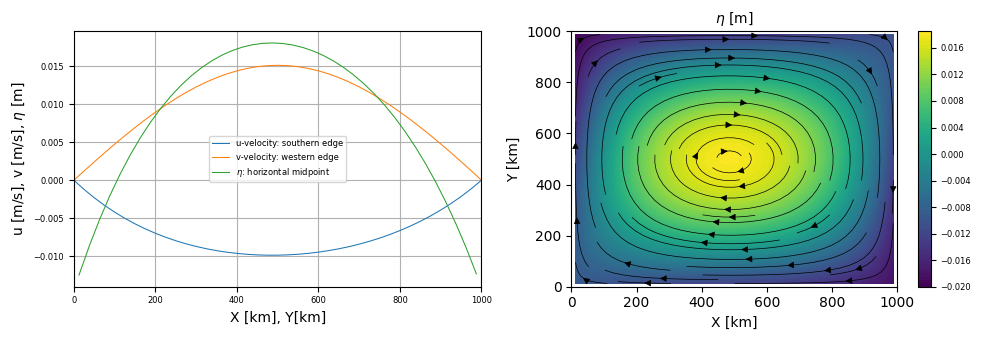

In [6]:
assign2.runTaskD1()

Figure 5: Numerical solutions from the forward-backward scheme after one day. The right-hand plot shows the height perturbation contour plot overlayed with the velocity streamlines. The left-hand plot shows different sections of the gyre: the u velocity along the southern edge, the v velocity along the western boundary, and the height perturbation through the midpoint of the gyre.

The results of Figure 5 confirm that the scheme is stable, and we can observe that the gyre is starting to form. The streamlines depict a clockwise rotation (anticyclonic in the northern hemisphere), and the height perturbation field is symmetric since the western boundary current has not yet formed. Notably, the maximum height perturbation occurs at the centre of the domain, with the vertical maximum position coinciding with the change in wind stress direction. This behaviour can be explained by considering that the wind stress exerts a clockwise torque on the flow. Ekman transport thus induces inward flow towards the centre of the gyre, resulting in a positive height perturbation at the interior, peaking at the centre, and negative perturbations beyond the boundaries. In the ocean, this would result in downwelling at the centre, but in our single-layer model we cannot observe this.

Along the western boundary, the meridional velocity moves poleward and has its maximum at the centre, again coinciding with the change in wind stress direction. Along the southern boundary, the zonal flow is westward and has its maximum coinciding with the horizontal maximum of the height perturbation. The location of these velocity maximum positions is perhaps due to the existence of the largest height perturbation gradients (pressure gradients) perpendicular to their respective flow directions.

### 4.2 Results at steady state 

The model is now run until steady state. In Section 5 it will be shown that this occurs after approximately after 40 days, and the results are shown in Figure 6. We can see that generally, there is good agreement between the numerical and analytical solutions.

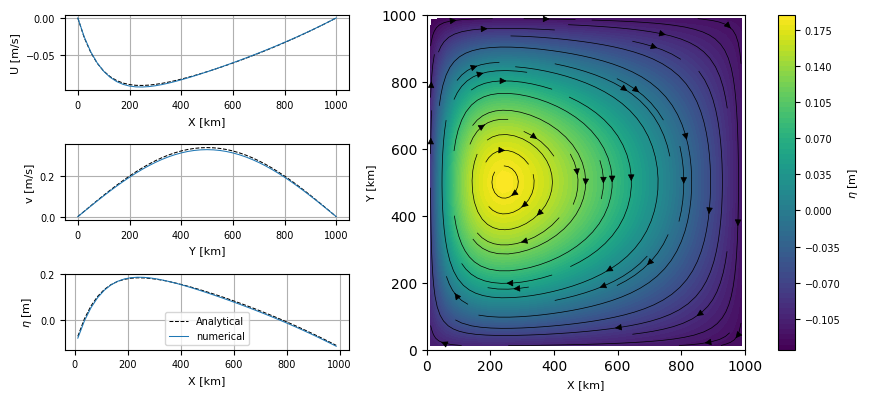

In [7]:
assign2.runTaskD2()

Figure 6: Numerical solutions of the forward-backward scheme after 40 days. The right-hand plot shows the height perturbation contour plot overlayed with the velocity streamlines. The left-hand plots show different sections of the gyre plotted against the analytical steady state solution from Section 3: the top plot shows the u velocity at the southern boundary, the middle plot shows the v velocity at the western boundary and the bottom plot shows $\eta$ along the gyre midsection.

In Figure 6, we observe significant zonal asymmetry in the gyre compared to Figure 5. The peak in surface elevation has shifted westward, and the velocities along the southern and western boundaries have increased. Notably, the maximum position of the westward zonal velocity along the southern edge has also shifted in alignment with the surface elevation peak. Furthermore, a pronounced crowding of streamlines is evident along the western boundary, coinciding with the location of maximum gradients in surface elevation. These observations indicate the formation of a western boundary current.

We can understand the steady state distribution of the gyre by considering the absolute vorticity budget of the gyre. Away from the boundaries, the gyre is approximately in Sverdrup balance, such that there is a simple balance between the advection of vorticity and the wind stress. 

### 4.3 Differences between steady state and the analytical model

Energy difference is 3.02e+12 J


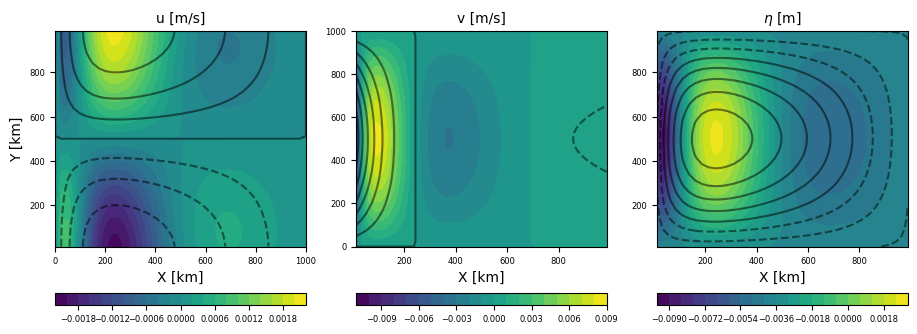

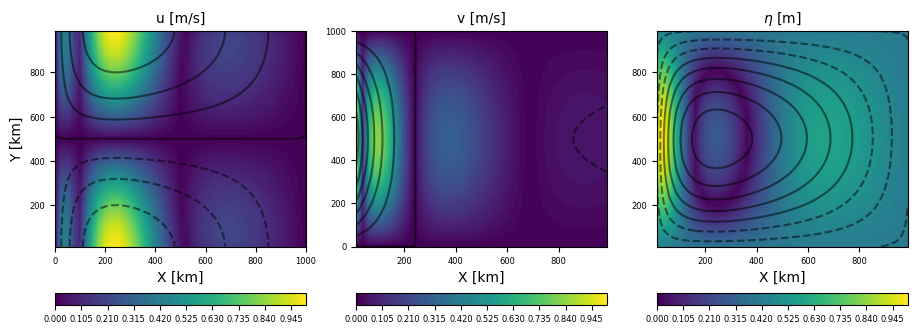

In [8]:
assign2.runTaskD3()

Figure 7: 

### 6. Task E for Energy

\begin{align}
E(u, v, \eta) = \int\limits_{0}^{L_x}\int\limits_{0}^{L_y} \left(\frac{1}{2}\rho\left(H(u^2 + v^2) + g\eta^2\right)\right) \, dx \, dy
\end{align}

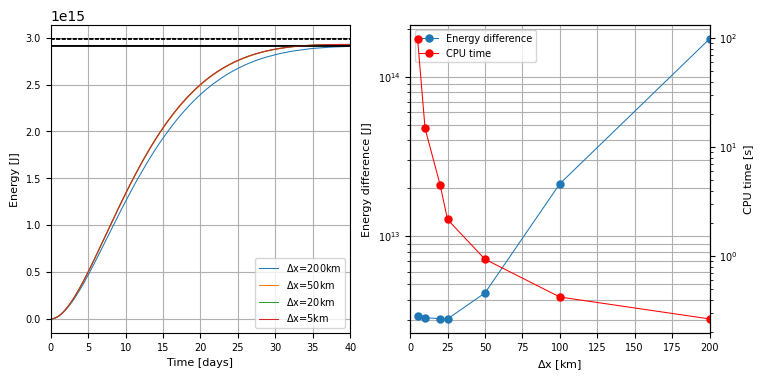

In [9]:
assign2.runTaskE() # Takes about 2.5 minutes on my laptop (running a few different resolutions).

Figure 8:

### 7. Task F/G: Comparison of time schemes

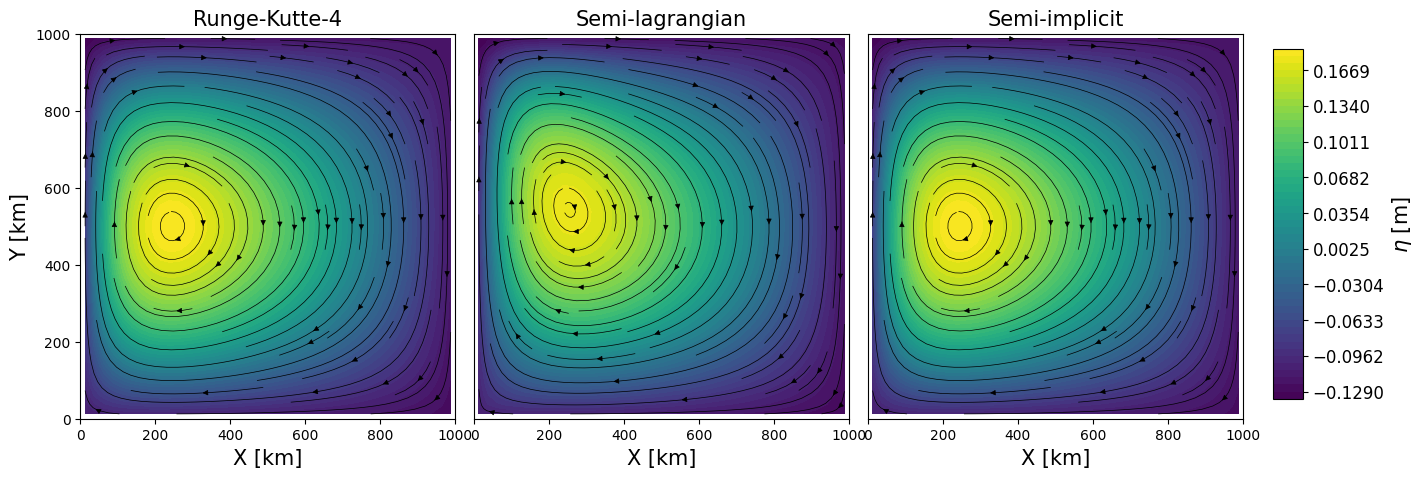

In [10]:
assign2.runTaskF1() # Height perturbation contours.

Figure 9: 

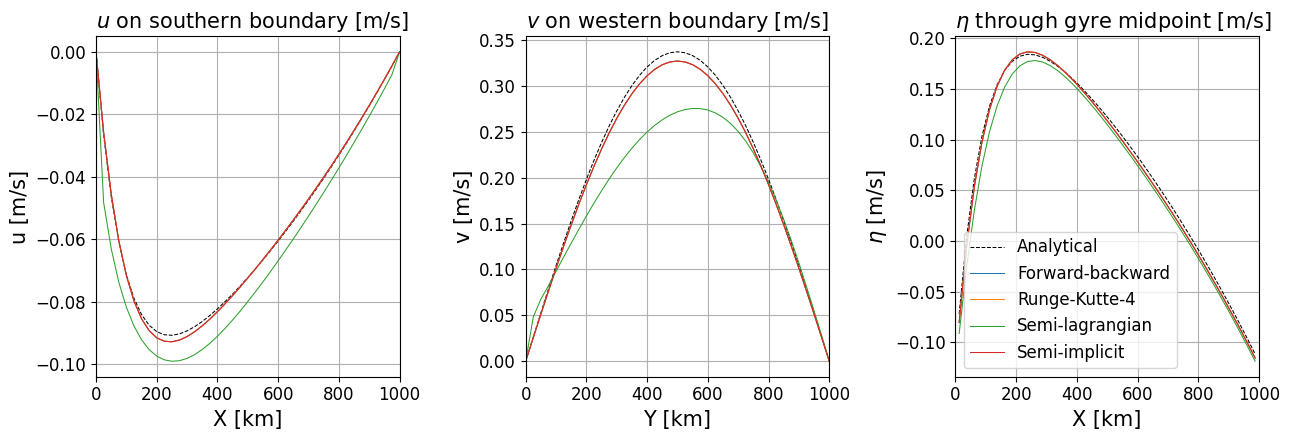

In [11]:
assign2.runTaskF2() # Gyre section comparisons.

Figure 10:

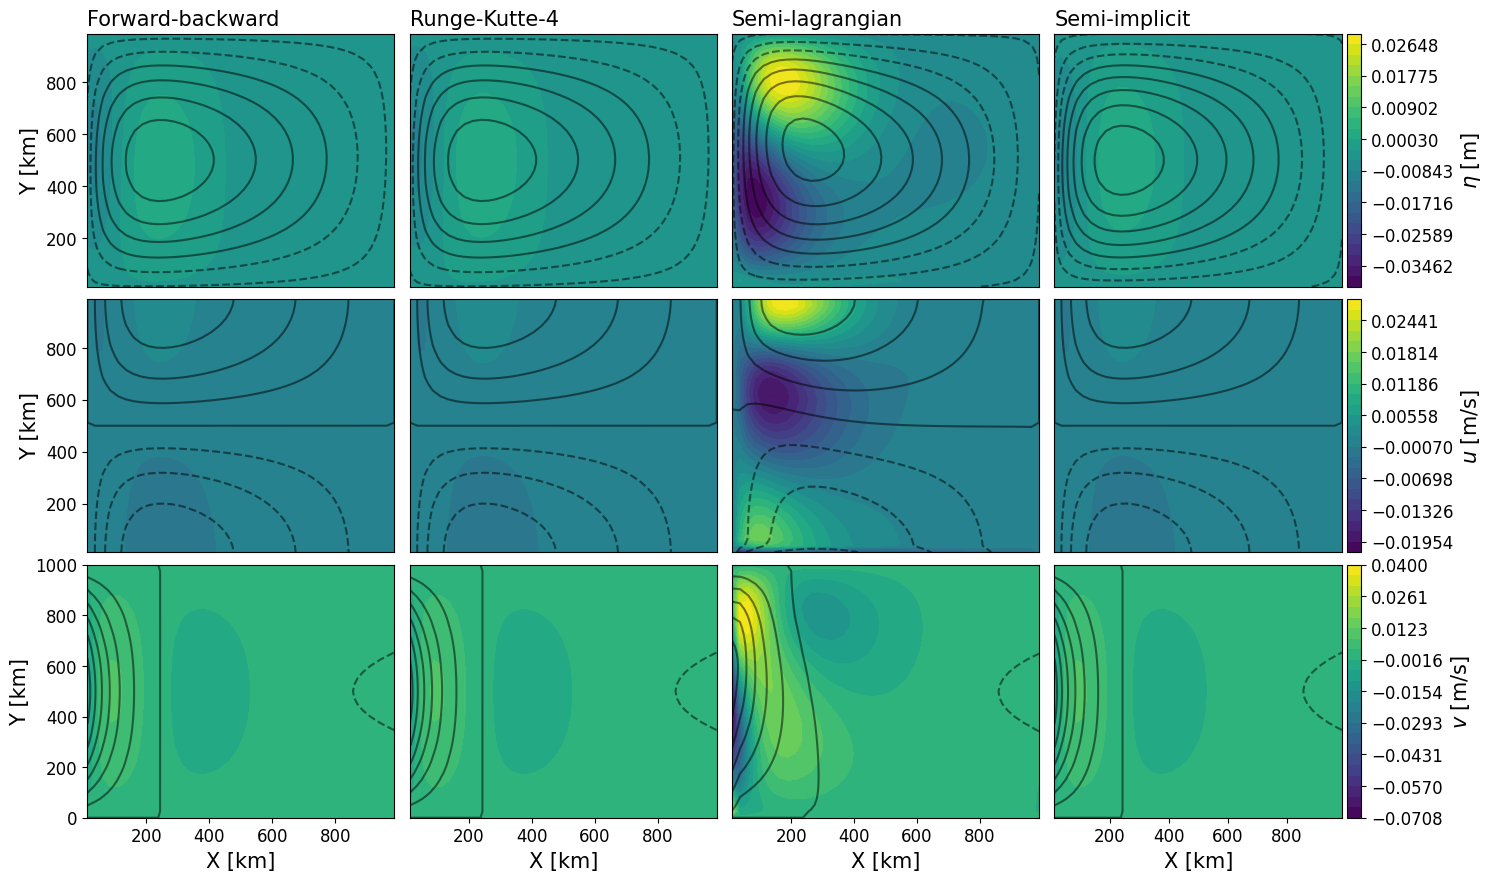

In [12]:
assign2.runTaskF3()

Figure 11: 

Max semi-implicit inverse matrix construction time: 0.671875
Min semi-implicit inverse matrix construction time: 0.0


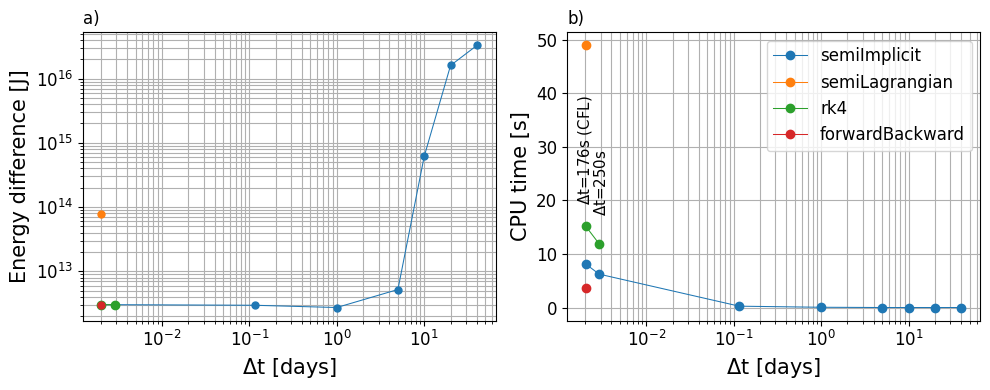

In [2]:
assign2.runTaskG() # Takes a long time to run as well.

Figure 12:

### References

### A. Appendix

#### A.1 Time schemes